In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler,RFormula
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder\
        .appName('MLib-spark-3')\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/09 23:10:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.parquet('/Users/xwyang/Desktop/sf-airbnb')

In [5]:
trainDF,testDF = df.randomSplit([0.8,0.2],seed=42)

In [6]:
categoryCols = [field for (field,datatype) in df.dtypes if datatype=='string']
inputIndex = [x+'Index' for x in categoryCols]
oheoutput = [x + 'OHE' for x in categoryCols]

In [7]:
stringIndex = StringIndexer(inputCols=categoryCols,outputCols=inputIndex,handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=inputIndex,outputCols=oheoutput)

In [8]:
numberiCols = [field for (field,datatype) in df.dtypes if ((datatype=='double') & (field !='price'))]

In [9]:
Allinputs= numberiCols + oheoutput

In [10]:
veAss = VectorAssembler(inputCols=Allinputs,outputCol='features')

In [11]:
lr = LinearRegression(featuresCol='features',labelCol='price',regParam=0.3)

In [12]:
pipeline = Pipeline(stages=[stringIndex,oheEncoder,veAss,lr])
pipeModel = pipeline.fit(trainDF)

24/08/09 23:11:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/08/09 23:11:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/09 23:11:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [13]:
preDF = pipeModel.transform(testDF)

In [14]:
reg_valuator = RegressionEvaluator(predictionCol='prediction',
                                  labelCol='price',
                                  metricName='rmse')

In [15]:
rmse = reg_valuator.evaluate(preDF)
print(f"RMSE is {rmse:.1f}")

RMSE is 218.0


In [16]:
preDF.select('features','price','prediction').show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(98,[0,1,2,3,4,5,...| 85.0| 60.87238167569808|
|(98,[0,1,2,3,4,5,...| 45.0|27.014087797057073|
|(98,[0,1,2,3,4,5,...| 70.0|31.406548966263927|
|(98,[0,1,2,3,4,5,...|128.0|-92.45430120536594|
|(98,[0,1,2,3,4,5,...|159.0| 94.02635696696757|
+--------------------+-----+------------------+
only showing top 5 rows



In [17]:
mean_value = trainDF.select(mean('price')).collect()[0][0]
mean_value

214.47249134948098

In [18]:
baseline_df = testDF.withColumn('baseline_prediction',lit(mean_value))


In [19]:
evaluator = RegressionEvaluator(predictionCol='baseline_prediction',
                                  labelCol='price',
                                  metricName='rmse')

In [20]:
rmse1 = evaluator.evaluate(baseline_df)
print(f"Baseline Model RMSE: {rmse1:.4f}")


Baseline Model RMSE: 240.7093


In [21]:
if rmse < rmse1:
    print("\nYour model performs better than the baseline model.")
else:
    print("Your model does not perform better than the baseline model.")


Your model performs better than the baseline model.


In [22]:
r2 = reg_valuator.setMetricName('r2').evaluate(preDF)
print(f"\nR2 is {r2:.4f}")


R2 is 0.1797


In [23]:
import pandas as pd
dff = pd.read_parquet('/Users/xwyang/Desktop/sf-airbnb')

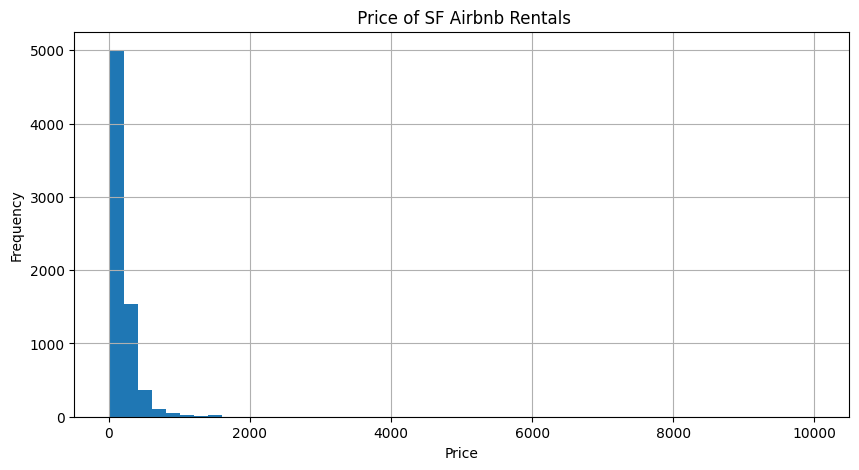

In [24]:
import matplotlib.pyplot as plt

dff['price'].hist(bins=50, figsize=(10, 5))
plt.title(' Price of SF Airbnb Rentals')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

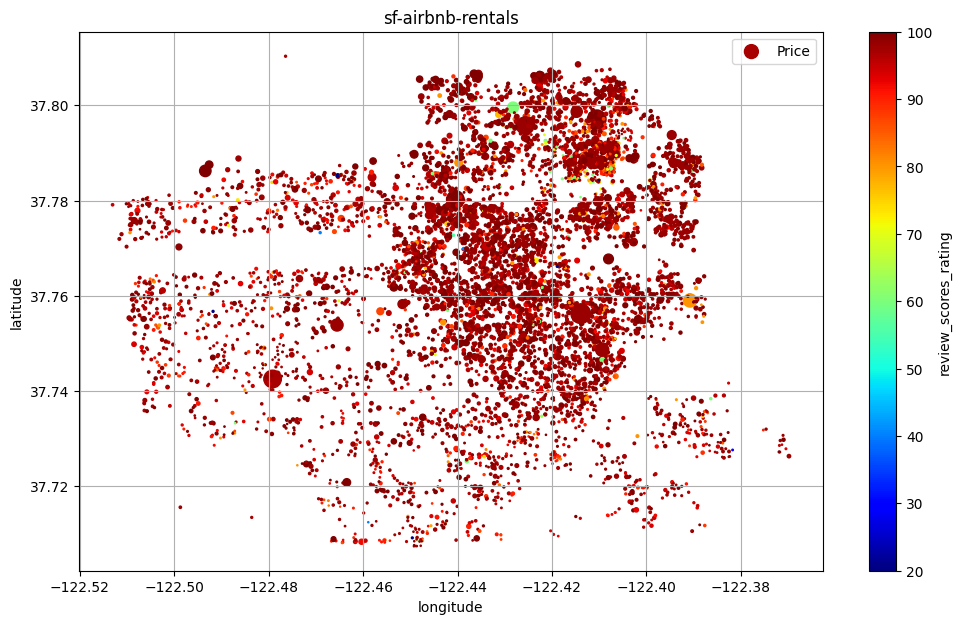

In [25]:
dff.plot(kind='scatter',x='longitude',y='latitude',c='review_scores_rating',
        s=dff.price/50,cmap='jet',colorbar=True,title='sf-airbnb-rentals',sharex=False,
        figsize=(12,7),grid=True,label='Price',legend=True)
plt.show()

In [26]:
import numpy as np
df_price = dff[['price']].apply(lambda x: np.log(x))

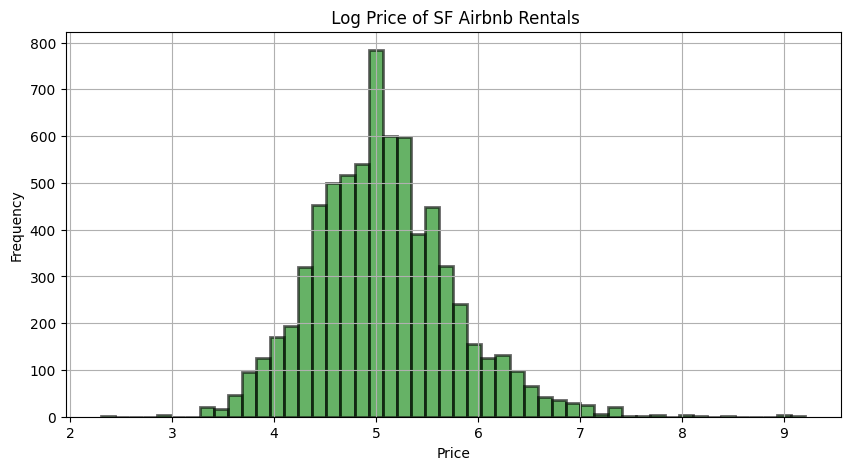

In [27]:
df_price.hist(bins=50, figsize=(10, 5),color='green',edgecolor='black',linewidth=2,alpha=0.6)
plt.title(' Log Price of SF Airbnb Rentals')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The R-squared (\( R^2 \)) metric is commonly used to evaluate the performance of a regression model. It provides a measure of how well the model's predictions match the actual data. Here's how you can measure the performance of your regression model using \( R^2 \) in PySpark.

### What is \( R^2 \)?

- **\( R^2 \) (Coefficient of Determination)**: It represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). The value of \( R^2 \) lies between 0 and 1:
  - \( R^2 = 1 \): Perfect prediction.
  - \( R^2 = 0 \): The model does not explain any of the variability in the target variable.
  - \( R^2 < 0 \): The model is worse than a horizontal line that predicts the mean of the target variable.



### Interpreting the Results

- **High \( R^2 \)**: If \( R^2 \) is close to 1, it indicates that the model explains most of the variance in the target variable, meaning it is performing well.
- **Low \( R^2 \)**: If \( R^2 \) is close to 0, it indicates that the model does not explain much of the variance in the target variable, meaning it may not be performing well.
- **Negative \( R^2 \)**: This could occur if your model is performing worse than simply predicting the mean of the target variable for all observations.

### Using \( R^2 \) Alongside Other Metrics

While \( R^2 \) is a useful metric, it should be considered alongside other metrics like RMSE (Root Mean Square Error) or MAE (Mean Absolute Error) to get a comprehensive view of the model's performance.

### Example: Using Multiple Metrics

```python
# Evaluate RMSE and MAE alongside R^2
rmse_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

rmse = rmse_evaluator.evaluate(predictions_df)
mae = mae_evaluator.evaluate(predictions_df)

print(f"R^2: {r2}, RMSE: {rmse}, MAE: {mae}")
```

### Summary

- \( R^2 \) measures how well the model explains the variance in the target variable.
- In PySpark, you can calculate \( R^2 \) using the `RegressionEvaluator` with `metricName="r2"`.
- High \( R^2 \) values indicate good model performance, while low or negative values suggest the model might not be performing well.
- Consider using \( R^2 \) in conjunction with other metrics like RMSE and MAE for a more complete assessment of your model's performance.